In [ ]:
!pip install tabula-py

In [1]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

#Number Manupulation & Plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tabula

#Model Selection Libraries
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

#Preprocessing Libraries
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

#Liner Model Libraries
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#pipeline libraries
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

import sklearn
import sklearn.decomposition

from sklearn.svm import SVC
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
df_teamDetail= pd.read_csv("Kabaddi-TeamDetailMetrics.csv")
df_teamDetail.drop(["BIGGEST WINNING MARGIN","HIGHEST SCORE","TOTAL DEFENCE POINTS"], inplace=True, axis=1)
df_teamDetail = df_teamDetail[~(df_teamDetail.Season == "OVERALL")]


cols = df_teamDetail.columns
raid = list(x for x in cols if "RAID" in x)
tackles = list(x for x in cols if "TACKLES" in x)
raid_tackles = raid + tackles
other = list(x for x in cols if  x not in raid_tackles)

In [3]:
#df_teamDetail.info()

In [4]:
print (df_teamDetail.shape)
#print (df_teamSum.shape)
#df_teamDetail.head()

(68, 23)


In [5]:
#df_team_merged.Metrics.unique()

In [6]:
#Create a new field
df_teamDetail['TOTAL SUPER'] =  df_teamDetail['NO. OF SUPER RAIDS']+ df_teamDetail['NO. OF SUPER TACKLES']
cols_to_scale = list(df_teamDetail.select_dtypes(["int32","int64","float64"]).columns)
#Predict
Y= ["FINISHING POSITION", 'NO. OF SUPER RAIDS', 'NO. OF SUPER TACKLES', 'TOTAL SUPER',
'SUCCESSFUL RAIDS','SUCCESSFUL TACKLES']

In [7]:
#df_teamDetail['FINISHING POSITION'].head()

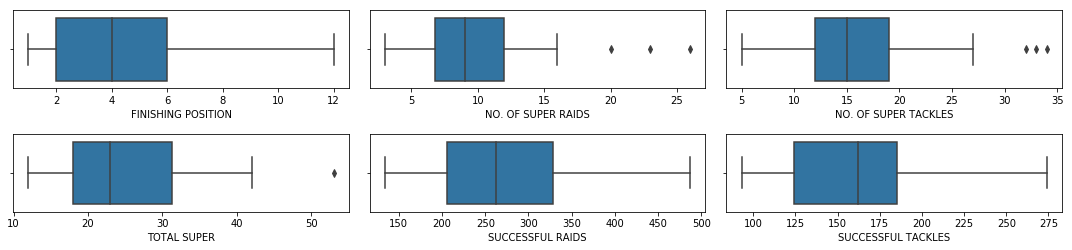

In [8]:
plt.figure(figsize=(15,10))
i=1
for pred in Y:
    plt.subplot(len(Y),3,i)
    sns.boxplot( df_teamDetail[pred])
    i+=1
plt.tight_layout()

#### Normalize Predicted Variables

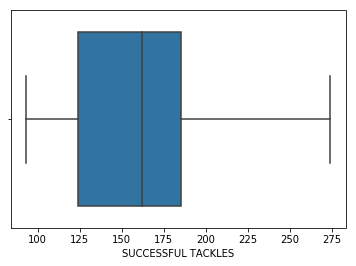

In [9]:
#sns.boxplot(np.log2(df_teamDetail['SUCCESSFUL TACKLES']))
sns.boxplot((df_teamDetail['SUCCESSFUL TACKLES']))

In [10]:
####Feature Engieering

df_teamDetail = df_teamDetail[np.log2(df_teamDetail['NO. OF SUPER TACKLES'])<5] # Remove Outlier

df_teamDetail['NO. OF SUPER RAIDS'] =  np.log2(df_teamDetail['NO. OF SUPER RAIDS'])
df_teamDetail['FINISHING POSITION'] =  np.log2(df_teamDetail['FINISHING POSITION'])
#df_teamDetail['SUCCESSFUL TACKLES'] =  np.log2(df_teamDetail['SUCCESSFUL TACKLES']) 
df_teamDetail['TOTAL SUPER']        =  np.log2(df_teamDetail['TOTAL SUPER'])

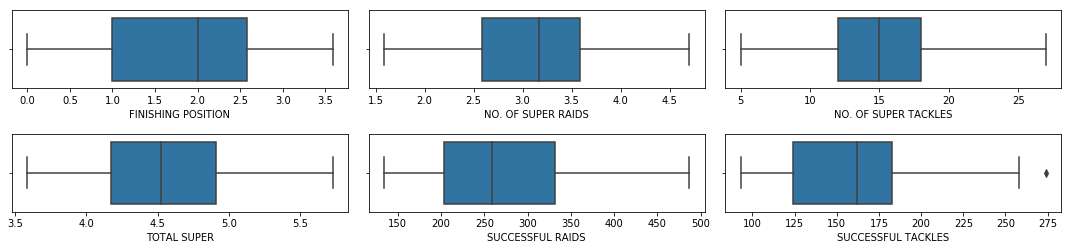

In [11]:
plt.figure(figsize=(15,10))
i=1
for pred in Y:
    plt.subplot(len(Y),3,i)
    sns.boxplot( df_teamDetail[pred])
    i+=1
plt.tight_layout()

#### Check Distribution Again

['MATCHES PLAYED', 'WINS', 'DRAWS', 'LOSSES', 'FINISHING POSITION', 'TOTAL RAIDS', 'SUCCESSFUL RAIDS', 'UNSUCCESSFUL RAID', 'EMPTY RAIDS', 'NO. OF SUPER RAIDS', 'RAID TOUCH POINTS', 'RAID BONUS POINTS', 'TOTAL RAID POINTS', 'TOTAL TACKLES', 'SUCCESSFUL TACKLES', 'UNSUCCESFUL TACKLES', 'NO. OF SUPER TACKLES', 'ALL OUTS INFLICTED', 'TOTAL ALL OUT POINTS', 'TOTAL SUPER']


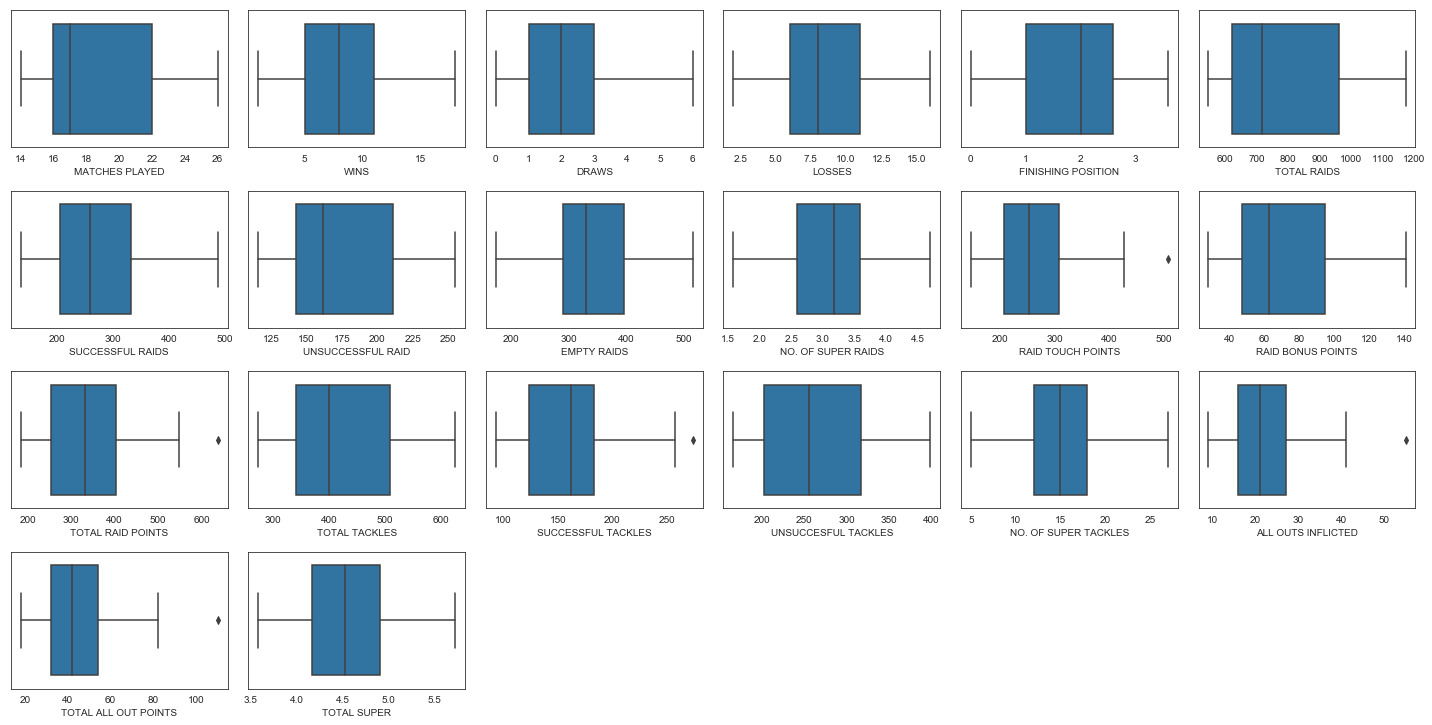

In [12]:
print (cols_to_scale)
sns.set_style("white")
plt.figure(figsize=(20,100))
i=1
while i<=len(cols_to_scale):
    plt.subplot(40,6,i)
    sns.boxplot( x=df_teamDetail[ cols_to_scale[i-1] ])
    i+=1
plt.tight_layout()
plt.show()

In [13]:
def get_train_validate_test_dataset(df,Metrics_Name):
    print ()
    if Metrics_Name=="":
        df_test2           = df [df.Season=="7"]
        df_player_Other    = df [df.Season!="7"]
        df_train, df_test1 = train_test_split(df_player_Other, test_size=.25, random_state=42)
    else:
        #df_team_merged_      = df_team_merged  [df_team_merged.Metrics == Metrics_Name]
        df_test2             = df [df.Season=="7"]
        df_team_Other        = df [df.Season!="7"]
        df_train, df_test1 = train_test_split(df_team_Other, test_size=.25, random_state=42)
        #df_train, df_test1 = train_test_split(df_team_merged, test_size=.25, random_state=42)
    return df_train, df_test1, df_test2

In [14]:
def PredictMetrics(df,Metrics_Name,cols_to_scale):
    #df_train, df_test1, df_test2 =  get_train_validate_test_dataset (df,Metrics_Name)
    df_train=df[0]
    df_test1=df[1]
    df_test2=df[2]
    #Scale Data
    sc = StandardScaler()
    df_train[cols_to_scale] = sc.fit_transform(df_train[cols_to_scale])
    df_test1[cols_to_scale] = sc.transform(df_test1[cols_to_scale])
    df_test2[cols_to_scale] = sc.transform(df_test2[cols_to_scale])

    y_train = df_train.pop(Metrics_Name)

    X_df_train = df_train

    y_test1 = df_test1.pop(Metrics_Name)
    X_df_test1 = df_test1

    y_test2 = df_test2.pop(Metrics_Name)
    X_df_test2 = df_test2

    ##Prepare Model
    #lr = LogisticRegression()
    lnr = LinearRegression()
    
    #cols=cols_to_scale.copy()
    #cols.remove(Metrics_Name)
    
    lnr.fit(X_df_train[cols_to_scale],y_train)

    y_test1_pred = lnr.predict(X_df_test1[cols_to_scale])

    y_test2_pred = lnr.predict(X_df_test2[cols_to_scale])


    return ([X_df_test1,X_df_test2],[y_test1,y_test2],[y_test1_pred,y_test2_pred])

In [15]:
def showPredictions(df, y_test, y_test_pred, Metrics_Name, pred_what, npfunc):
    X_df_test1 = df[0]
    X_df_test2 = df[1]
    y_test1 = y_test[0]
    y_test2 = y_test[1]
    y_test1_pred = y_test_pred[0]
    y_test2_pred = y_test_pred[1]
    
    ##Prediction- Validation Data******************************************************
    pred_cols={"Season": X_df_test1.Season}
    if pred_what=="Player":
        pred_cols["Player"] = X_df_test1.Player                
    else:
        pred_cols["Team"]= X_df_test1.Team
                  
    pred_cols["Prediction"]= getMath_ScaledValue (npfunc,y_test1_pred)
    pred_cols["Actual"]    = getMath_ScaledValue (npfunc,y_test1)
    
    pred_total_score = pd.DataFrame(pred_cols)
    pred_total_score = pred_total_score.sort_values("Prediction", ascending=True)
    print("Prediction Results on Test Data", Metrics_Name)
    print("r2 score : ", round(metrics.r2_score(y_test1,y_test1_pred),2))
    print(pred_total_score)
    
    ##Prediction- Test Data******************************************************
    pred_cols={"Season": X_df_test2.Season}
    if pred_what=="Player":
        pred_cols["Player"] = X_df_test2.Player                 
    else:
        pred_cols["Team"]= X_df_test2.Team
                  
    pred_cols["Prediction"]= getMath_ScaledValue (npfunc,y_test2_pred)
    pred_cols["Actual"]    = getMath_ScaledValue (npfunc,y_test2)
 

    pred_total_score = pd.DataFrame(pred_cols)
    pred_total_score = pred_total_score.sort_values("Prediction", ascending=True)
    print("\nPrediction Results for Season 7", Metrics_Name)
    print("r2 score : ", round(metrics.r2_score(y_test2,y_test2_pred),2))
    print(pred_total_score)

In [16]:
def getMath_ScaledValue(npfunc, orgval):
    if npfunc=="":
        return orgval
    elif npfunc=="log2":
        return 2**orgval
    elif npfunc=="sqrt":
        return orgval*orgval

In [18]:
cols_to_scale1=cols_to_scale.copy()
cols_to_scale1.remove(Y[0])
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (df_teamDetail,Y[0])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
df, y_test, y_test_pred = PredictMetrics([df_train,df_test1,df_test2],Y[0],cols_to_scale1)
showPredictions(df, y_test, y_test_pred, Y[0],"team","log2")


Train: (40, 24) Test1: (14, 24) Test2: (11, 24)


D:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


Prediction Results on Test Data FINISHING POSITION
r2 score :  0.69
   Season                  Team  Prediction  Actual
73      3              U Mumbai    1.349878     1.0
78      6           U.P. Yoddha    2.460568     3.0
66      2       Bengaluru Bulls    2.612861     3.0
32      4         Patna Pirates    2.909292     1.0
72      4              U Mumbai    3.242016     4.0
22      2         Telugu Titans    3.287897     2.0
30      6         Patna Pirates    3.507285     4.0
10      6      Haryana Steelers    4.025089     6.0
14      6       Tamil Thalaivas    4.586000     6.0
21      3         Telugu Titans    4.688129     5.0
50      2  Jaipur Pink Panthers    5.260065     5.0
7       1     Dabang Delhi K.C.    5.626415     6.0
42      2         Puneri Paltan    8.239384     8.0
5       3     Dabang Delhi K.C.    9.121416     8.0

Prediction Results for Season 7 FINISHING POSITION
r2 score :  0.63
   Season                   Team  Prediction  Actual
1       7      Dabang Delhi K.

In [19]:
cols_to_scale1=cols_to_scale.copy()
cols_to_scale1.remove(Y[1])
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (df_teamDetail,Y[1])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
df, y_test, y_test_pred = PredictMetrics([df_train,df_test1,df_test2],Y[1],cols_to_scale1)
showPredictions(df, y_test, y_test_pred, Y[1],"team","log2")


Train: (40, 24) Test1: (14, 24) Test2: (11, 24)


D:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


Prediction Results on Test Data NO. OF SUPER RAIDS
r2 score :  0.83
   Season                  Team  Prediction  Actual
72      4              U Mumbai    3.718500     4.0
21      3         Telugu Titans    3.984178     3.0
73      3              U Mumbai    4.611974     7.0
7       1     Dabang Delhi K.C.    4.629120     5.0
50      2  Jaipur Pink Panthers    5.923736     5.0
32      4         Patna Pirates    6.095156     7.0
5       3     Dabang Delhi K.C.    6.618113     5.0
14      6       Tamil Thalaivas    8.195589     7.0
42      2         Puneri Paltan    8.198087     8.0
66      2       Bengaluru Bulls    8.351918    10.0
78      6           U.P. Yoddha    9.386657    10.0
10      6      Haryana Steelers   10.527940    12.0
30      6         Patna Pirates   10.660308    11.0
22      2         Telugu Titans   17.232698    16.0

Prediction Results for Season 7 NO. OF SUPER RAIDS
r2 score :  0.74
   Season                   Team  Prediction  Actual
25      7  Gujarat Fortunegian

In [20]:
cols_to_scale1=cols_to_scale.copy()
cols_to_scale1.remove(Y[2])
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (df_teamDetail,Y[2])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
df, y_test, y_test_pred = PredictMetrics([df_train,df_test1,df_test2],Y[2],cols_to_scale1)
showPredictions(df, y_test, y_test_pred, Y[2],"team","")


Train: (40, 24) Test1: (14, 24) Test2: (11, 24)


D:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


Prediction Results on Test Data NO. OF SUPER TACKLES
r2 score :  0.91
   Season                  Team  Prediction  Actual
73      3              U Mumbai    2.282566       6
66      2       Bengaluru Bulls    6.376474       7
7       1     Dabang Delhi K.C.    9.195574      10
72      4              U Mumbai   10.574085      11
42      2         Puneri Paltan   11.234908      11
10      6      Haryana Steelers   14.817713      15
5       3     Dabang Delhi K.C.   15.373329      13
14      6       Tamil Thalaivas   15.821305      15
30      6         Patna Pirates   16.012302      16
22      2         Telugu Titans   16.547624      16
21      3         Telugu Titans   17.297125      15
50      2  Jaipur Pink Panthers   19.043694      18
32      4         Patna Pirates   23.557677      27
78      6           U.P. Yoddha   25.134717      27

Prediction Results for Season 7 NO. OF SUPER TACKLES
r2 score :  0.85
   Season                   Team  Prediction  Actual
1       7      Dabang Delh

In [21]:
cols_to_scale1=cols_to_scale.copy()
cols_to_scale1.remove(Y[3])
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (df_teamDetail,Y[3])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
df, y_test, y_test_pred = PredictMetrics([df_train,df_test1,df_test2],Y[3],cols_to_scale1)
showPredictions(df, y_test, y_test_pred, Y[3],"team","log2")


Train: (40, 24) Test1: (14, 24) Test2: (11, 24)


D:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


Prediction Results on Test Data TOTAL SUPER
r2 score :  0.94
   Season                  Team  Prediction  Actual
73      3              U Mumbai   15.569725    13.0
72      4              U Mumbai   15.591714    15.0
7       1     Dabang Delhi K.C.   15.601684    15.0
21      3         Telugu Titans   16.074619    18.0
5       3     Dabang Delhi K.C.   16.421040    18.0
66      2       Bengaluru Bulls   18.032956    17.0
42      2         Puneri Paltan   18.819593    19.0
50      2  Jaipur Pink Panthers   21.442365    23.0
14      6       Tamil Thalaivas   21.458840    22.0
30      6         Patna Pirates   27.383900    27.0
10      6      Haryana Steelers   28.573994    27.0
22      2         Telugu Titans   29.972847    32.0
32      4         Patna Pirates   35.827361    34.0
78      6           U.P. Yoddha   40.228625    37.0

Prediction Results for Season 7 TOTAL SUPER
r2 score :  0.91
   Season                   Team  Prediction  Actual
13      7        Tamil Thalaivas   15.652135

In [22]:
cols_to_scale1=cols_to_scale.copy()
cols_to_scale1.remove(Y[4])
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (df_teamDetail,Y[4])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
df, y_test, y_test_pred = PredictMetrics([df_train,df_test1,df_test2],Y[4],cols_to_scale1)
showPredictions(df, y_test, y_test_pred, Y[4],"team","")


Train: (40, 24) Test1: (14, 24) Test2: (11, 24)


D:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


Prediction Results on Test Data SUCCESSFUL RAIDS
r2 score :  1.0
   Season                  Team  Prediction  Actual
42      2         Puneri Paltan       170.0     170
5       3     Dabang Delhi K.C.       171.0     171
50      2  Jaipur Pink Panthers       183.0     183
72      4              U Mumbai       188.0     188
66      2       Bengaluru Bulls       194.0     194
73      3              U Mumbai       206.0     206
21      3         Telugu Titans       206.0     206
32      4         Patna Pirates       206.0     206
7       1     Dabang Delhi K.C.       246.0     246
22      2         Telugu Titans       265.0     265
14      6       Tamil Thalaivas       344.0     344
78      6           U.P. Yoddha       357.0     357
10      6      Haryana Steelers       361.0     361
30      6         Patna Pirates       406.0     406

Prediction Results for Season 7 SUCCESSFUL RAIDS
r2 score :  1.0
   Season                   Team  Prediction  Actual
77      7            U.P. Yoddha    

In [23]:
cols_to_scale1=cols_to_scale.copy()
cols_to_scale1.remove(Y[5])
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (df_teamDetail,Y[5])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
df, y_test, y_test_pred = PredictMetrics([df_train,df_test1,df_test2],Y[5],cols_to_scale1)
showPredictions(df, y_test, y_test_pred, Y[5],"team","")


Train: (40, 24) Test1: (14, 24) Test2: (11, 24)


D:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


Prediction Results on Test Data SUCCESSFUL TACKLES
r2 score :  1.0
   Season                  Team  Prediction  Actual
5       3     Dabang Delhi K.C.        98.0      98
21      3         Telugu Titans       101.0     101
42      2         Puneri Paltan       104.0     104
72      4              U Mumbai       110.0     110
7       1     Dabang Delhi K.C.       124.0     124
50      2  Jaipur Pink Panthers       124.0     124
32      4         Patna Pirates       145.0     145
66      2       Bengaluru Bulls       158.0     158
22      2         Telugu Titans       158.0     158
73      3              U Mumbai       163.0     163
14      6       Tamil Thalaivas       174.0     174
10      6      Haryana Steelers       180.0     180
30      6         Patna Pirates       186.0     186
78      6           U.P. Yoddha       240.0     240

Prediction Results for Season 7 SUCCESSFUL TACKLES
r2 score :  1.0
   Season                   Team  Prediction  Actual
13      7        Tamil Thalaivas

<font size=6, color=red>Creating Player Dataset from pdf files</font>

In [24]:
folders = ["Bangalore","Delhi","Bengal"]
folders = ["Bangalore"]

<font size=5 color=red>__LINE BELOW WILL OVER-WRITE THE EXISTING FILES!!!!__<font/>

#Convert all pds files in CSV
for folder in folders:
    print(folder)
    files=os.listdir("players\\"+folder)
    for f in files:
        f1 = f.split(".")
        print ("players\\folder\\"+f1[0]+".csv")
        
        if f1[1]=="pdf":
            tabula.convert_into("players\\"+folder+"\\"+f, "players\\"+folder+"\\"+f1[0]+".csv", output_format="csv")

In [25]:
def massage_ds(df1):
    df1.SEASONS [df1.SEASONS=="EARNED"] ="TOTAL POINTS EARNED"
    df1.SEASONS [ (df1.SEASONS=="MATCH") & (df1.index<6) ] = "MOST POINTS IN A MATCH"
    df1.SEASONS [df1.SEASONS=="MATCH"] = "AVERAGE TACKLE / MATCH"
    df1.SEASONS [df1.SEASONS=="%"] = "SUCCESSFUL RAIDS %"
    df1.SEASONS [df1.SEASONS=="POINTS / MATCH"] = "AVERAGE RAID POINTS / MATCH"
    df1.SEASONS [df1.SEASONS=="TACKLES"] = "NO OF SUPER TACKLES"
    df1.SEASONS [df1.SEASONS=="POINTS"] = "TOTAL TACKLE POINTS"
    df1.SEASONS [df1.SEASONS=="TACKLE STRIKE RATE"] ="TACKLE STRIKE RATE %"
    df1=df1[~df1.OVERALL.isna()]
    return df1

In [26]:
### Read all CSV files into dataset. Massage all dataset. Put datasets in array datasets
dfs=[]
for folder in folders:
    print(folder)
    files=os.listdir("players\\"+folder)
    for f in files:
        f1 = f.split(".")
      
        if f1[1]=="csv":
            file="players\\"+folder+"\\"+f1[0]+".csv"
            
            print(file)
            df= pd.read_csv(file)
            df = massage_ds(df)
            
            df["Player"]=f1[0]
            df["Team"]=folder
            
            dfs.append(df)

Bangalore
players\Bangalore\ajay-profile-2353.csv
players\Bangalore\aman-profile-2501.csv
players\Bangalore\amit-sheoran-profile-794.csv
players\Bangalore\ankit-profile-2471.csv
players\Bangalore\ashish-kumar-profile-202.csv
players\Bangalore\banty-profile-2503.csv
players\Bangalore\lbanty-profile-2503.csv
players\Bangalore\mahender-singh-profile-769.csv
players\Bangalore\mohit-sehrawat-profile-2502.csv
players\Bangalore\pawan-sehrawat-profile-318.csv
players\Bangalore\raju-lal-choudhary-profile-87.csv
players\Bangalore\rohit-kumar-profile-326.csv
players\Bangalore\sandeep-profile-299.csv
players\Bangalore\sanjay-shrestha-profile-15.csv
players\Bangalore\saurabh-nandal-profile-2670.csv
players\Bangalore\sumit-singh-profile-363.csv
players\Bangalore\vijay-kumar-profile-768.csv
players\Bangalore\vinod-kumar-profile-387.csv


In [27]:
###Merge All Datasets
First=True
for d in dfs:
    if First:
        df=d
        First=False
    else: 
        df = pd.concat([df, d])
        
df.drop(columns=["Unnamed: 4","Unnamed: 5","Unnamed: 6","Unnamed: 7","Unnamed: 8","Unnamed: 9"], inplace=True)

In [28]:
#Reduce Dataset Columns Season 1, Season 2 etc to Season.
col1= ['Player', 'SEASONS', 'Team']
i=1
while i<=7:
    s="SEASON "+str(i)
    col2=col1.copy()
    col2.append(s)
    if i==1:
        df2 = df[col2]
        df2= df2.rename(columns = { s : "Score"})
        df2['Season']=i

    else:
        df_temp=df[col2]
        df_temp= df_temp.rename(columns = { s : "Score"})
        df_temp['Season']=i
        
        df2 = pd.concat( [df2, df_temp ], axis=0)
    i+=1

In [29]:
#Transform the final dataset
df2=df2[~df2.Score.isna()]

df2= df2.rename(columns = { "SEASONS" : "Metrics"})
df2.index = np.arange(len(df2))
df2[ ['Score','Junk'] ] = df2.Score.str.split(" ", expand=True)
df2.Metrics = df2.Metrics.str.replace("?","")
df2.drop(columns="Junk", inplace=True)

df2=df2[~df2.Score.isna()]

In [30]:
df2.head()

,Player,Metrics,Team,Score,Season
0,raju-lal-choudhary-profile-87,MATCHES PLAYED,Bangalore,5,1
1,raju-lal-choudhary-profile-87,TOTAL POINTS EARNED,Bangalore,2,1
2,raju-lal-choudhary-profile-87,MOST POINTS IN A MATCH,Bangalore,2,1
3,raju-lal-choudhary-profile-87,NOT OUT %,Bangalore,0,1
4,raju-lal-choudhary-profile-87,TOTAL RAIDS,Bangalore,0,1


In [31]:
###Transorm Players Dataset
metrics_list = list(df2.Metrics.unique())
df2.index = df2.Player+"|"+df2.Season.astype(str)

i=0
while i< len(metrics_list):

    df_temp = df2[df2.Metrics==metrics_list[i]]
    df_temp = df_temp.rename(columns={"Score":metrics_list[i]})
    
    if i==0:
        df_temp.drop(columns=["Metrics","Player","Season"],inplace=True)
        df_players = df_temp
    else:
        df_temp.drop(columns=["Metrics","Player","Season","Team"],inplace=True)
        df_players = pd.concat([df_players,df_temp], axis=1)
    i+=1
    
df_players = df_players.reset_index()
df_players= df_players.rename(columns={"index":"id"})
df_players[ ['Player','Season'] ] = df_players.id.str.split("|", expand=True)
df_players.drop(columns=["id"],inplace=True)

In [32]:
#df_players.info()

In [33]:
#df_players.head()

In [34]:
#Change Datatypes
df_players['MATCHES PLAYED']           =df_players['MATCHES PLAYED'].astype(int)
df_players[ 'TOTAL POINTS EARNED']     =df_players[ 'TOTAL POINTS EARNED'].astype(int)
df_players[ 'MOST POINTS IN A MATCH']  =df_players[ 'MOST POINTS IN A MATCH'].astype(int)
df_players[ 'NOT OUT % ']              =df_players[ 'NOT OUT % '].astype(float)
df_players[ 'TOTAL RAIDS']             =df_players[ 'TOTAL RAIDS'].astype(int)
df_players[ 'SUCCESSFUL RAIDS %']      =df_players[ 'SUCCESSFUL RAIDS %'].astype(float)
df_players[ 'NO OF SUPER RAIDS']       =df_players[ 'NO OF SUPER RAIDS'] .astype(int)
df_players[ 'SUPER 10S ']              =df_players[ 'SUPER 10S '].astype(int)
df_players[ 'TOTAL RAID POINTS']       =df_players[ 'TOTAL RAID POINTS'].astype(int)
df_players[ 'AVERAGE RAID POINTS / MATCH'] =df_players[ 'AVERAGE RAID POINTS / MATCH'].astype(float)
df_players[ 'NO OF SUPER TACKLES']     =df_players[ 'NO OF SUPER TACKLES'].astype(int)
df_players[ 'HIGH 5S ']                =df_players[ 'HIGH 5S '].astype(int)
df_players[ 'TOTAL TACKLE POINTS']     =df_players[ 'TOTAL TACKLE POINTS'].astype(int)
df_players[ 'AVERAGE TACKLE / MATCH']  =df_players[ 'AVERAGE TACKLE / MATCH'].astype(float)
df_players[ 'TOTAL TACKLES']           =df_players[ 'TOTAL TACKLES'].astype(int)
df_players[ 'TACKLE STRIKE RATE %']    =df_players[ 'TACKLE STRIKE RATE %'].astype(float)

In [35]:
cols_to_scale = list(df_players.select_dtypes(["int32","float64"]).columns)

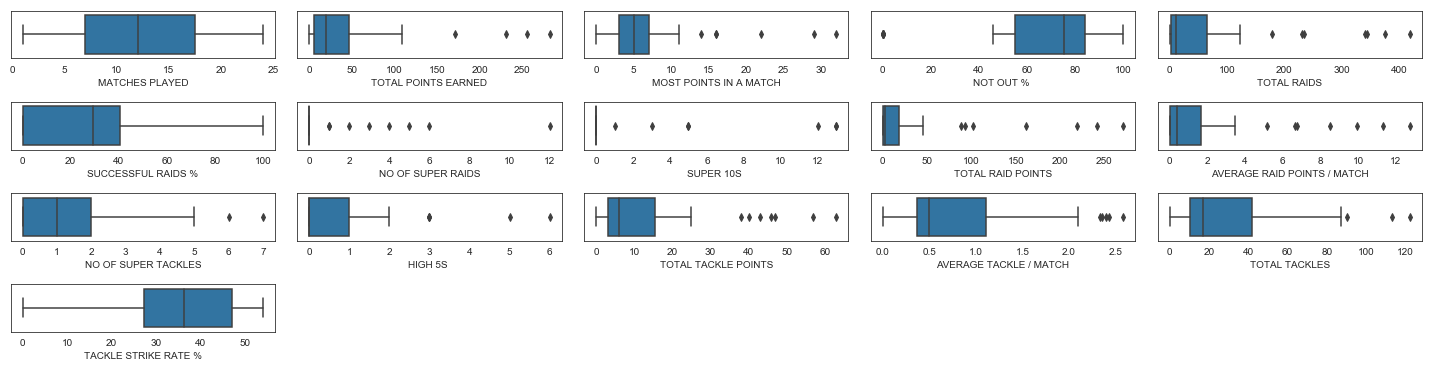

In [36]:
plt.figure(figsize=(20,20))
i=1
for f in cols_to_scale:
    plt.subplot(len(cols_to_scale), 5,i)
    sns.boxplot((df_players[f]))
    i+=1
    
plt.tight_layout()

## Feature Engineering

In [37]:
#These columns has too much abnormal data and by any meant it cannot be normalzied
df_players.drop(columns=["NO OF SUPER RAIDS", "SUPER 10S "], inplace=True)
cols_to_scale = list(df_players.select_dtypes(["int32","float64"]).columns)

In [38]:
#Normal : No change required
#Matches player
#Tacle strike rate


#TOTAL TACKLE POINTS	AVERAGE TACKLE / MATCH	TOTAL TACKLES
#TOTAL POINTS EARNED	MOST POINTS IN A MATCH	NOT OUT %	TOTAL RAIDS


#SQRT -(If create log2 data get normalized but they get -inf)
df_players[ 'TOTAL POINTS EARNED']   = np.sqrt(np.sqrt(df_players[ 'TOTAL POINTS EARNED']))
df_players[ 'MOST POINTS IN A MATCH'] = np.sqrt(df_players[ 'MOST POINTS IN A MATCH'])
df_players[ 'NOT OUT % ']            = np.sqrt(df_players[ 'NOT OUT % ']) 
df_players[ 'TOTAL RAIDS']            = np.sqrt(np.sqrt(df_players[ 'TOTAL RAIDS']))
df_players[ 'TOTAL TACKLE POINTS']    = (np.sqrt(df_players[ 'TOTAL TACKLE POINTS']))
df_players[ 'AVERAGE TACKLE / MATCH'] =  (np.sqrt(df_players[ 'AVERAGE TACKLE / MATCH']))
df_players[ 'TOTAL TACKLES']          = (np.sqrt(df_players[ 'TOTAL TACKLES']))

#**.5
df_players[ 'SUCCESSFUL RAIDS %'] = df_players[ 'SUCCESSFUL RAIDS %']**.5
df_players[ 'HIGH 5S ']           = df_players[ 'HIGH 5S ']**.5

##sine
df_players[ 'AVERAGE RAID POINTS / MATCH'] = np.sin(df_players[ 'AVERAGE RAID POINTS / MATCH'])
df_players["TOTAL RAID POINTS"] = np.sin(df_players["TOTAL RAID POINTS"])

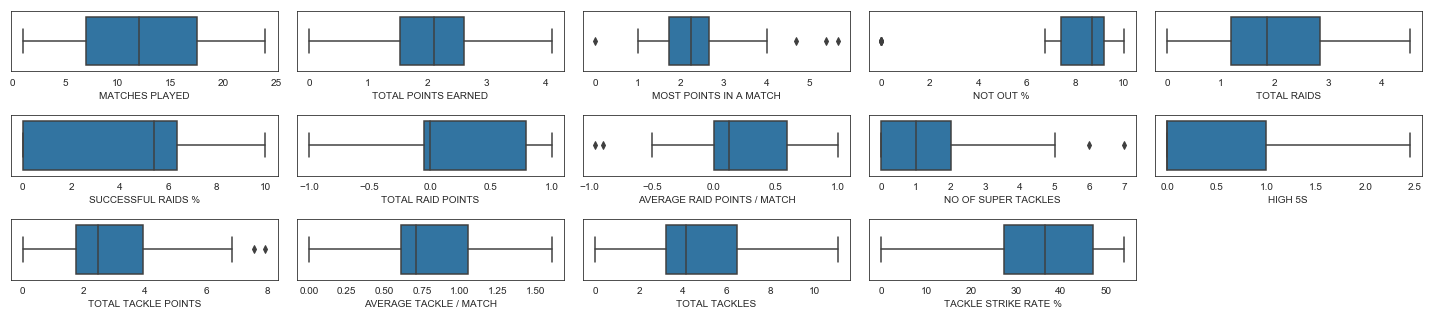

In [39]:
plt.figure(figsize=(20,20))
i=1
for f in cols_to_scale:
    plt.subplot(len(cols_to_scale), 5,i)
    sns.boxplot(( (df_players[f])) )
    i+=1
    
plt.tight_layout()

In [40]:
df_players.describe()

,MATCHES PLAYED,TOTAL POINTS EARNED,MOST POINTS IN A MATCH,NOT OUT %,TOTAL RAIDS,SUCCESSFUL RAIDS %,TOTAL RAID POINTS,AVERAGE RAID POINTS / MATCH,NO OF SUPER TACKLES,HIGH 5S,TOTAL TACKLE POINTS,AVERAGE TACKLE / MATCH,TOTAL TACKLES,TACKLE STRIKE RATE %
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,12.372093,2.182625,2.402503,7.201151,2.017354,4.100596,0.072983,0.242176,1.209302,0.402231,3.053671,0.809511,4.940359,34.796047
std,6.669130,0.868848,1.121257,3.569104,1.330984,3.313320,0.675678,0.470727,1.753339,0.707831,2.064605,0.405668,2.679254,14.257496
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.999990,-0.956969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,1.530217,1.732051,7.408517,1.189207,0.000000,-0.048606,0.000000,0.000000,0.000000,1.732051,0.608276,3.239451,27.385000
50%,12.000000,2.114743,2.236068,8.691950,1.861210,5.400000,0.000000,0.119712,1.000000,0.000000,2.449490,0.707107,4.123106,36.360000
75%,17.500000,2.618219,2.645751,9.177963,2.843595,6.353672,0.787341,0.590498,2.000000,1.000000,3.936492,1.050000,6.478902,47.050000
max,24.000000,4.097909,5.656854,10.000000,4.521620,10.000000,0.999912,0.998248,7.000000,2.449490,7.937254,1.606238,11.045361,54.020000


In [41]:
Y=["SUCCESSFUL RAIDS %","TOTAL TACKLE POINTS"]

In [42]:
cols_to_scale1=cols_to_scale.copy()
cols_to_scale1.remove(Y[0])
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (df_players,Y[0])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
df, y_test, y_test_pred = PredictMetrics([df_train,df_test1,df_test2],Y[0],cols_to_scale1)
showPredictions(df, y_test, y_test_pred, Y[0],"team","sqrt")


Train: (22, 17) Test1: (8, 17) Test2: (13, 17)


D:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


Prediction Results on Test Data SUCCESSFUL RAIDS %
r2 score :  0.15
   Season       Team  Prediction  Actual
27      6  Bangalore    2.802895    0.00
28      6  Bangalore    5.176775   40.74
8       4  Bangalore    7.202027   33.33
9       4  Bangalore   14.581869   39.74
23      6  Bangalore   25.200390    0.00
17      5  Bangalore   26.292626   33.33
15      5  Bangalore   44.550136   52.39
24      6  Bangalore   78.772137   72.26

Prediction Results for Season 7 SUCCESSFUL RAIDS %
r2 score :  0.42
   Season       Team  Prediction  Actual
31      7  Bangalore    0.233836    0.00
32      7  Bangalore    1.822058    0.00
35      7  Bangalore   12.428467   40.00
41      7  Bangalore   14.557947   39.13
33      7  Bangalore   14.607618    0.00
37      7  Bangalore   17.215082   11.11
42      7  Bangalore   19.733556    0.00
36      7  Bangalore   26.086073    0.00
34      7  Bangalore   34.860904    8.33
39      7  Bangalore   45.086571   38.26
38      7  Bangalore   48.097467   70.55
30

In [43]:
cols_to_scale1=cols_to_scale.copy()
cols_to_scale1.remove(Y[1])
df_train, df_test1, df_test2 =  get_train_validate_test_dataset (df_players,Y[1])
print ("Train:",df_train.shape, "Test1:",df_test1.shape, "Test2:",df_test2.shape )
df, y_test, y_test_pred = PredictMetrics([df_train,df_test1,df_test2],Y[1],cols_to_scale1)
showPredictions(df, y_test, y_test_pred, Y[1],"team","sqrt")


Train: (22, 17) Test1: (8, 17) Test2: (13, 17)


D:\Users\admin\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Users\admin\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
D:\Users\admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


Prediction Results on Test Data TOTAL TACKLE POINTS
r2 score :  0.96
   Season       Team  Prediction  Actual
8       4  Bangalore    0.544678     0.0
28      6  Bangalore    1.849911     4.0
9       4  Bangalore    4.334638     7.0
17      5  Bangalore    5.701021     5.0
15      5  Bangalore   10.021723    12.0
24      6  Bangalore   13.041674    11.0
27      6  Bangalore   15.162244    16.0
23      6  Bangalore   67.377645    63.0

Prediction Results for Season 7 TOTAL TACKLE POINTS
r2 score :  0.97
   Season       Team  Prediction  Actual
31      7  Bangalore    0.979662     1.0
35      7  Bangalore    1.564973     3.0
41      7  Bangalore    1.774117     3.0
30      7  Bangalore    3.827397     2.0
39      7  Bangalore    5.099394     4.0
42      7  Bangalore    6.642725     5.0
34      7  Bangalore    6.760424     5.0
33      7  Bangalore    7.430962     6.0
38      7  Bangalore    9.979309    14.0
37      7  Bangalore   13.250621    12.0
32      7  Bangalore   44.133807    43.0
